In [137]:
using Plots
using LightGraphs
using LinearAlgebra
using BenchmarkTools
using SparseArrays
using Random
using LaTeXStrings
using Flux
using GraphRecipes
using GraphPlot
using Random
using StatsBase
using Distributions


LoadError: [91mArgumentError: Package OneHotArrays not found in current path:[39m
[91m- Run `import Pkg; Pkg.add("OneHotArrays")` to install the OneHotArrays package.[39m


In [140]:
using OneHotArrays

LoadError: [91mArgumentError: Package OneHotArrays not found in current path:[39m
[91m- Run `import Pkg; Pkg.add("OneHotArrays")` to install the OneHotArrays package.[39m


In [139]:
onehot(:b, [:a, :b, :c])

LoadError: [91mUndefVarError: onehot not defined[39m

In [2]:
function randomPopulateMat(mat,symmetric=true)
    for ii = 1:round(Int, percPopulate*size(mat)[1] )
        row_tmp = rand( 1:size(mat)[1] )
        col_tmp = rand( 1:size(mat)[1] )
        if( row_tmp == col_tmp )
            col_tmp = rand( deleteat!( collect(1:size(mat)[1]), row_tmp ) )            
        end
        mat[row_tmp,col_tmp] = 1
        if(symmetric == true)
            mat[col_tmp,row_tmp] = 1
        end
    end
    return mat
end

randomPopulateMat (generic function with 2 methods)

In [3]:
function A2S(AdjMat)
    AdjMat += I #add the identity to the diagonal, add self-loops
    diag = Diagonal(vec(sum(AdjMat,dims=2) .^ (-1/2)))
    return (diag) * AdjMat * (diag) #return the normalized S matrix
end

A2S (generic function with 1 method)

In [4]:
function A2k(SMat,k)
    return SMat^k
end

A2k (generic function with 1 method)

In [5]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 20
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 5

5

In [6]:
benchmarkDicts = Dict()
benchmarkDicts["time"] = []
benchmarkDicts["memory"] = []
benchmarkDicts["gctime"] = []
benchmarkDicts["allocs"] = []
NN = [10^k for k in 1:5] #[10^1,10^2,10^3,10^4,10^5]
percPopulate = 0.1
for ii in 1:length(NN)
    NNtmp = NN[ii]
    AA = spzeros(NNtmp,NNtmp);
    AA = randomPopulateMat(AA);
    bb = @benchmark A2S($AA)
    push!(benchmarkDicts["time"],mean(bb).time)
    push!(benchmarkDicts["memory"],mean(bb).memory)
    push!(benchmarkDicts["gctime"],mean(bb).gctime)
    push!(benchmarkDicts["allocs"],mean(bb).allocs)
    
end

In [7]:
benchmarkDicts["time"]

5-element Array{Any,1}:
   1228.6078947368424
   5626.35
  48162.9
 492905.35
      4.5224228e6

In [8]:
benchmarkDicts["memory"]

5-element Array{Any,1}:
     2656
    14048
   124896
  1227712
 12261648

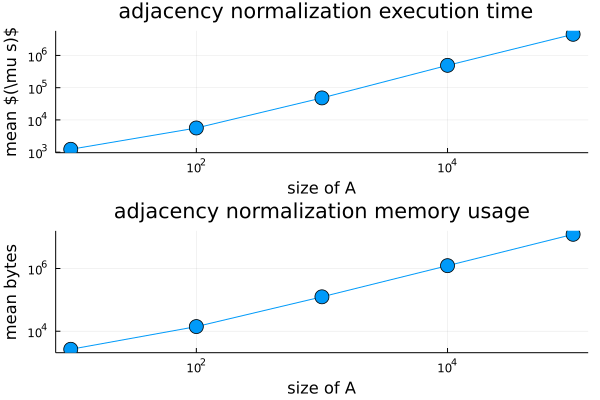

In [9]:
pTime = plot( NN , benchmarkDicts["time"] ,markershape=:circle, markersize=8 ,
        legend = false , xaxis=:log , yaxis=:log)
xlabel!("size of A")
ylabel!("mean " * L"(\mu s)")
title!(" adjacency normalization execution time")
pMemory = plot( NN , benchmarkDicts["memory"] ,markershape=:circle, markersize=8 ,
        legend = false , xaxis=:log , yaxis=:log)
xlabel!("size of A")
ylabel!("mean bytes")
title!("adjacency normalization memory usage")
plot(pTime, pMemory, layout = Plots.grid(2,1) )

In [10]:
benchmarkDicts_k = Dict()
benchmarkDicts_k["time"] = []
benchmarkDicts_k["memory"] = []
benchmarkDicts_k["gctime"] = []
benchmarkDicts_k["allocs"] = []
NN = [10^6]
percPopulate = 0.1
NNtmp = NN[1]
AA = spzeros(NNtmp,NNtmp);
AA = randomPopulateMat(AA);
AS = A2S(AA)
K = [0,1,2,3,4,6]
for ii in 1:length(K)
    kk = K[ii]
    bb = @benchmark A2k(AS,$kk)
    push!(benchmarkDicts_k["time"],mean(bb).time)
    push!(benchmarkDicts_k["memory"],mean(bb).memory)
    push!(benchmarkDicts_k["gctime"],mean(bb).gctime)
    push!(benchmarkDicts_k["allocs"],mean(bb).allocs)
    
end

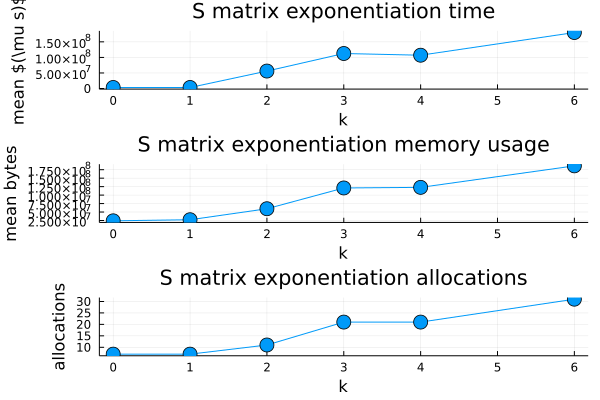

In [11]:
pTime = plot( K , benchmarkDicts_k["time"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("mean " * L"(\mu s)")
title!("S matrix exponentiation time")
pMemory = plot( K , benchmarkDicts_k["memory"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("mean bytes")
title!("S matrix exponentiation memory usage")
pAllocs = plot( K , benchmarkDicts_k["allocs"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("allocations")
title!("S matrix exponentiation allocations")
plot(pTime, pMemory, pAllocs, layout = Plots.grid(3,1) )

In [86]:
NN_set = [10^k for k in 2:4];

In [94]:
ER_BA_SF_WS_Block_graphs = Dict()
ER_BA_SF_WS_Block_matrices = Dict()
for nn in 1:length(NN_set)    
    
    NN_tmp = Int( NN_set[nn] / 4 )    
    
    ER_tmp = erdos_renyi( NN_tmp , 10*(NN_tmp) )
    BA_tmp = barabasi_albert( NN_tmp , 8 )
    SF_tmp = static_scale_free( NN_tmp , 8*(NN_tmp) , 4 )
    WS_tmp = erdos_renyi( NN_tmp , 10*(NN_tmp) ) #barabasi_albert( NN_tmp , 5 )
    blocks_tmp = blockdiag( blockdiag( blockdiag(ER_tmp,BA_tmp),SF_tmp ), WS_tmp )
    
    ER_BA_SF_WS_Block_graphs[nn] = blockdiag( blockdiag( blockdiag(ER_tmp,BA_tmp),SF_tmp ), WS_tmp )
    #now add some edges between the blocks that are the communities
    #>>>>    
    for bb in 1:Int(round(NN_tmp/10))
        for b1 in 0:3
            for b2 in 0:3
                if(b1 < b2)
                    range1 = randperm(NN_tmp)[1] + b1*NN_tmp
                    range2 = randperm(NN_tmp)[1] + b2*NN_tmp
                    add_edge!( ER_BA_SF_WS_Block_graphs[nn] , range1 , range2 )
                end
            end
        end
    end
    #<<<<
end
[ ER_BA_SF_WS_Block_matrices[ii] = Matrix(adjacency_matrix(ER_BA_SF_WS_Block_graphs[ii])) for ii in 1:length(NN_set) ]
ER_BA_SF_WS_Block_graphs

Dict{Any,Any} with 3 entries:
  2 => {1000, 9086} undirected simple Int64 graph
  3 => {10000, 91436} undirected simple Int64 graph
  1 => {100, 848} undirected simple Int64 graph

In [95]:
[ is_connected( ER_BA_SF_WS_Block_graphs[ii] ) for ii in 1:length(NN_set) ]

3-element Array{Bool,1}:
 1
 1
 1

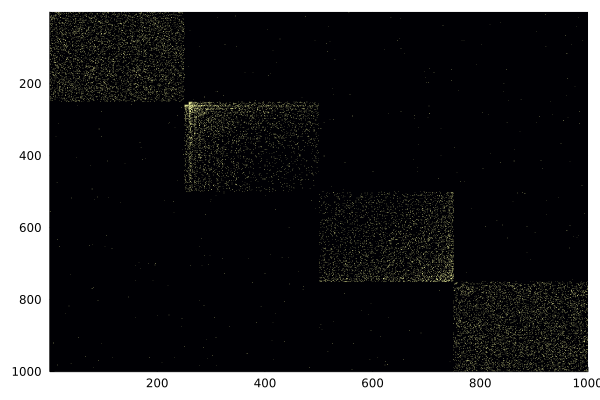

In [97]:
heatmap( ER_BA_SF_WS_Block_matrices[2] , yflip = true , legend = false )

In [98]:
#the X variable data...

In [126]:
d1 = Dirichlet([2,5,8])


Dirichlet{Int64,Array{Int64,1},Float64}(alpha=[2, 5, 8])

In [132]:
x1 = rand(d1,10)

3×10 Array{Float64,2}:
 0.0962761  0.00556537  0.170361  0.19414   …  0.0587509  0.139997  0.179594
 0.122767   0.49177     0.231259  0.284077     0.395193   0.537641  0.139425
 0.780957   0.502665    0.59838   0.521783     0.546056   0.322362  0.680981

In [133]:
c1 = Categorical([0.2,0.3,0.5])

DiscreteNonParametric{Int64,Float64,Base.OneTo{Int64},Array{Float64,1}}(support=Base.OneTo(3), p=[0.2, 0.3, 0.5])

In [134]:
rand( c1 , 10 )

10-element Array{Int64,1}:
 3
 1
 2
 3
 2
 3
 3
 3
 3
 3

In [116]:
X_tmp = []
for ii in 1:size(ER_BA_SF_WS_Block_matrices[1])[1]
    
    
    
end

100×1 Array{Int64,2}:
 20
 19
 21
 21
 21
 18
 19
 18
 17
 20
 22
 22
 22
  ⋮
 20
 18
 19
 22
 21
 23
 20
 21
 21
 23
 19
 18

In [72]:
@benchmark A2S(AA)

BenchmarkTools.Trial: 100 samples with 6 evaluations.
 Range (min … max):   6.906 μs …  14.133 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      9.935 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.012 μs ± 751.256 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                             ▂█▃▆▂▆█▂  ▅ █                      
  ▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▁▁▁▁▁▁▇███████████▇█▅▇▄▅▄▁▁▁▁▁▁▁▁▁▁▄▁▁▁▄ ▄
  6.91 μs         Histogram: frequency by time         12.4 μs <

 Memory estimate: 13.77 KiB, allocs estimate: 22.

In [7]:
function adjacency2Smatrix(AdjMat)
    Adj = deepcopy(AdjMat)
    #make the diagonal for the adj matrix
    diag1 = zeros(size(Adj)[1],size(Adj)[2])
    [diag1[i,i]=1 for i in 1:size(diag1)[1]] 
    #add self-loops as the paper describes
    Adj .+= diag1
    #get degree matrix
    degrees = sum(Adj,dims=2)
    diag2 = zeros(size(Adj)[1],size(Adj)[2])
    [diag2[i,i]=degrees[i] for i in 1:size(diag1)[1]] 
    #make the diagonal matrix to the power of -1/2
    diag2 = diag2^(-1/2)
    #make the normalized S matrix
    S = diag2 * Adj * diag2
    return S
end

adjacency2Smatrix (generic function with 1 method)

In [9]:
as = adjacency2Smatrix(aa);
println(sum( (as)^1 ))
#println(sum( (as)^10 ))
#println(sum( (as)^100 ))
@btime adjacency2Smatrix(aa);

79.96632649518878
79.97113699635344
79.97113699587598
  64.377 μs (115 allocations: 260.78 KiB)


In [181]:
#now some synthetic data

In [118]:
function vizMatrixNormed(Adj,powerInd)#multiple dispatch
    global NN1
    hAdjNN1 = heatmap(Adj,title="Normalized Adjacency (S), k=$(powerInd)",
        showaxis=true,yaxis=:flip,aspect_ratio=1.0,
        framestyle=:box,xlims=(0.0,NN1+1.0),
        legend=true,ylims=(0.0,NN1+0.5),
        yticks=0:5:NN1,xticks=0:5:NN1,
        fill=cgrad([:white,:black]))
    return hAdjNN1
end

vizMatrixNormed (generic function with 1 method)

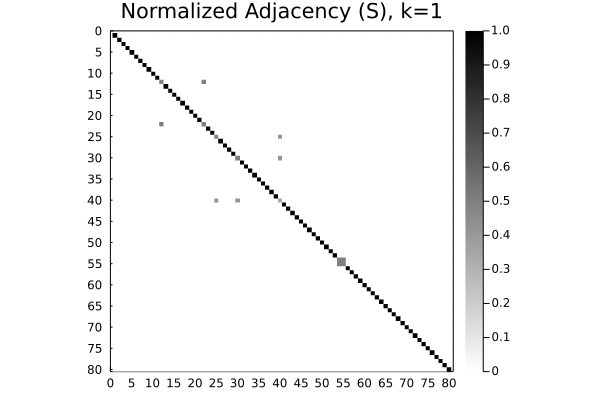

In [123]:
#adjMatrixNorm = adjacency2Smatrix(deepcopy(adjMatrix))
NN1 = 80
hVarX2 = vizMatrixNormed(as,1)

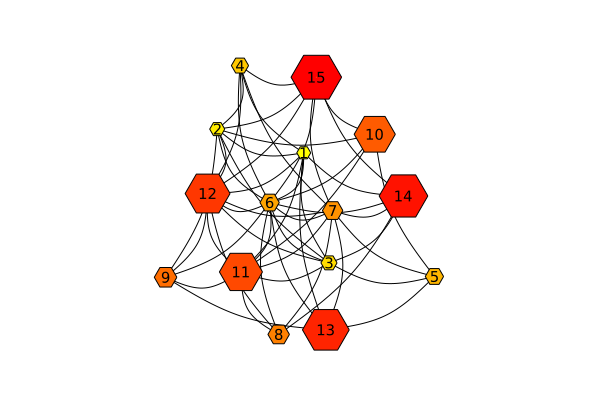

In [62]:
using GraphRecipes
using Plots

const n = 15
const A = Float64[ rand() < 0.5 ? 0 : rand() for i=1:n, j=1:n]
for i=1:n
    A[i, 1:i-1] = A[1:i-1, i]
    A[i, i] = 0
end

graphplot(A,
          markersize = 0.2,
          node_weights = 1:n,
          markercolor = range(colorant"yellow", stop=colorant"red", length=n),
          names = 1:n,
          fontsize = 10,
          linecolor = :darkgrey
          )